In [19]:
# import os
# os.environ['PATH'] += r';D:\Program Files\Microsoft Visual Studio\2022\Community\MSBuild\Current\Bin'

In [20]:
# !git clone https://github.com/aksnzhy/xlearn.git

In [22]:
# %cd xlearn
#!mkdir build
#%cd build

In [23]:
#!cmake -G "Visual Studio 17" -A x64 ../ && "D:\\Program Files\\Microsoft Visual Studio\\2022\\Community\\VC\\Auxiliary\\Build\\vcvarsall.bat" x64

In [24]:
#!MSBuild xLearn.sln /p:Configuration=Release

In [25]:
# %cd python-package
# !python setup.py install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

- date_time - время показа рекламы
- oaid_hash - хэш юзера
- zone_id - id зоны, где зона - место на сайте для размещения рекламы
- banner_id - id баннера, где баннер - сама реклама
- campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
- os_id - id операционной системы
- country_id - id страны  
- clicks - был ли клик

Не будем использовать 'impressions': в прошлый раз выяснили, что это бесполезно.

In [2]:
data0 = pd.read_csv('data.csv',
                   usecols=['date_time', 'oaid_hash', 'zone_id', 'banner_id',
                            'campaign_clicks','os_id', 'country_id', 'clicks'],
                   parse_dates=['date_time']
                  )
data0.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1


In [3]:
print(f'data size: {data0.shape}')

data size: (15821472, 8)


Новая фича только 'oaid_hash'. Посмотрим на нее, а также на даты.

Check data values:
date_time
2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: count, dtype: int64

oaid_hash has 6510316 different values


campaign_clicks values range [0,829]


lets check cumulative hour values:


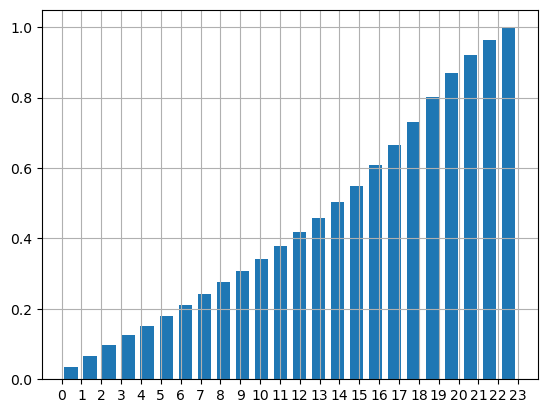

In [57]:
def analysis(df: pd.DataFrame):
    print('Check data values:')
    print(df['date_time'].dt.date.value_counts(), end='\n\n')
    
    print(f"{'oaid_hash'} has {len(np.unique(df['oaid_hash'].values))} different values\n\n")

    print(f"campaign_clicks values range [{min(df['campaign_clicks'].values)},{max(df['campaign_clicks'].values)}]\n\n")

    print('lets check cumulative hour values:')
    plt.hist(df['date_time'].dt.hour, 
         bins=24, 
         cumulative=True, 
         density=True,
         rwidth=0.7)
    plt.xticks(list(range(24)))
    plt.grid(True)
    plt.show()

analysis(data0)

Во-первых, уберем выброс:

In [3]:
data = data0[data0['date_time'].dt.date != pd.to_datetime('2021-09-01').date()]

In [14]:
data.shape

(15821471, 8)

Во-вторых, как и в прошлый раз мы оставим от даты только часы. Но в этот раз учтем прошлые ошибки и поделим для валидации по часам. По гистограмме видно, что 80% это до примерно до 19 часов включительно. Это в дальнейшем выделим в трейн, остальное - валидация. 
Проверим:

In [48]:
print(f"train < 20 val/train: {len(data[data['date_time'].dt.hour > 19]) / len(data[data['date_time'].dt.hour < 20])}")
print(f"train < 21 val/train: {len(data[data['date_time'].dt.hour > 20]) / len(data[data['date_time'].dt.hour < 21])}")

train < 20 val/train: 0.2477245930071302
train < 21 val/train: 0.14954870240224621


Лучше используем второй вариант.

Разобьем датасет:

In [4]:
data_train_val = data[data['date_time'].dt.date != pd.to_datetime('2021-10-02').date()]
data_val = data_train_val[data_train_val['date_time'].dt.hour > 20]
data_train = data_train_val[data_train_val['date_time'].dt.hour < 21]

data_test = data[data['date_time'].dt.date == pd.to_datetime('2021-10-02').date()]

y_train = data_train['clicks']
y_val = data_val['clicks']
y_test = data_test['clicks']

 
Далее будет использоваться ffm. Из этого следует несколько нюансов обработки:

1) Как написано в статье: "Note that according to the number of possible values in a categorical feature, the same number of binary features are generated and every time only one of them has the value 1. In the LIBSVM (LIBFFM) format, features with zero values are not stored".  То есть не будем применять OneHot явно, просто при формирвоании ffm датасета напишем 1, где нужно. Строка в ffm датасете будет выглядеть так: `label field_idx:field_featureValue_idx:1 ...`
2) "There are two possible ways to assign fields. A naive way is to treat each feature as a dummy field, so the generated data is : `feature:feature:feature_val`. However, the dummy fields may not be informative because they are merely duplicates of features. Another possible way is to discretize each numerical feature to a categorical one. Then, we can use the same setting for categorical features to add field information. The generated data looks like:  `label field_idx:feature_val:1` ." Дискретизировать не придется, у нас не категориальная фича int. Также получается, что скейлить не надо.

Получается, нам надо только даты превратить в часы.

In [16]:
def feature_engineering(df):
    modified_df = df.copy(deep=True)
    modified_df['hour'] = df['date_time'].dt.hour
    modified_df = modified_df.drop('date_time', axis=1)
    return modified_df
    
modified_X_train = feature_engineering(data_train)
modified_X_val = feature_engineering(data_val)
modified_X_test = feature_engineering(data_test)
modified_X_train.head()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks,hour
0,0,0,5664530014561852622,0,0,0,1,0
3,3,3,6262169206735077204,0,1,1,1,0
4,4,4,4778985830203613115,0,1,0,1,0
5,5,5,2377014068362699676,0,2,2,1,0
6,6,6,6863358899511896876,0,3,0,1,0


Я могу придумать только два fields (user и adv), что смысла не имеет. Возьмем тогда каждую фичу за field, все равно не много фичей.

Нам надо будет заэнкодить значения, создадим словарик, чтобы применить кодировку к валидационной и тренировочной выборке.

In [58]:
encoder_field_featureVal = {"cur_code": 830,
                            "codes": {}}
# поле b в a:b:1 не должно повторяться
# но мы относимся к численной фиче(она у нас одна) как к категориальной: field_idx:feature_val:1
# тогда feature_val будет принимать значения до max(numerical feature) = 829 у численной фичи
# поэтому для категориальных фичей надо начать со следующего числа

In [59]:
def make_ffm_data(df, data_type, encoder_field_featureVal):
    features = [f for f in df.columns.values.tolist() if f != 'clicks']

    with open(data_type + '.txt', "w+") as file:
        for row_idx in tqdm(range(df.shape[0])):
            #cur_string = ""
            cur_row = df.iloc[row_idx].to_dict()
            cur_str = f"{cur_row['clicks']}"
            #cur_str = str(int(cur_row['clicks']))

            for feature_idx, feature in enumerate(features):
                # с численной фичей разбираемся, как было написано выше
                if feature == 'campaign_clicks':
                    cur_str += f" {feature_idx}:{cur_row['campaign_clicks']}:1"
                else:
                    # если первый раз видим фичу, добавляем ей словарик и энкодим значение
                    if feature not in encoder_field_featureVal['codes']:
                        encoder_field_featureVal['codes'][feature] = {}
                        encoder_field_featureVal['codes'][feature][cur_row[feature]] = encoder_field_featureVal['cur_code']
                        encoder_field_featureVal['cur_code'] += 1

                    # если фича есть, но значение новое
                    elif cur_row[feature] not in encoder_field_featureVal['codes'][feature]:
                        encoder_field_featureVal['codes'][feature][cur_row[feature]] = encoder_field_featureVal['cur_code']
                        encoder_field_featureVal['cur_code'] += 1

                    code = encoder_field_featureVal['codes'][feature][cur_row[feature]]
                    cur_str += f" {feature_idx}:{code}:1"

            cur_str += '\n'
            file.write(cur_str)

# inspired by: https://xlearn-doc.readthedocs.io/en/latest/tutorial/index.html  (tutorial)

In [ ]:
make_ffm_data(modified_X_train, 'train', encoder_field_featureVal)

In [61]:
with open('train.txt', 'r') as file:
    for i in range(5):
        line = file.readline()
        print(line)

1 0:830:1 1:831:1 2:832:1 3:0:1 4:833:1 5:834:1 6:835:1

1 0:836:1 1:837:1 2:838:1 3:0:1 4:839:1 5:840:1 6:835:1

1 0:841:1 1:842:1 2:843:1 3:0:1 4:839:1 5:834:1 6:835:1

1 0:844:1 1:845:1 2:846:1 3:0:1 4:847:1 5:848:1 6:835:1

1 0:849:1 1:850:1 2:851:1 3:0:1 4:852:1 5:834:1 6:835:1



In [ ]:
make_ffm_data(modified_X_val, 'val',encoder_field_featureVal)

In [64]:
with open('val.txt', 'r') as file:
    for i in range(5):
        line = file.readline()
        print(line)

1 0:861:1 1:2762:1 2:5034601:1 3:0:1 4:833:1 5:840:1 6:5034602:1

1 0:1078:1 1:947:1 2:10813:1 3:3:1 4:833:1 5:834:1 6:5034603:1

1 0:961:1 1:947:1 2:5034604:1 3:0:1 4:833:1 5:834:1 6:5034603:1

1 0:882:1 1:4483:1 2:4924806:1 3:0:1 4:839:1 5:874:1 6:5034603:1

1 0:914:1 1:901:1 2:307447:1 3:3:1 4:833:1 5:834:1 6:5034603:1



In [ ]:
make_ffm_data(modified_X_test, 'test', encoder_field_featureVal)

In [66]:
with open('test.txt', 'r') as file:
    for i in range(5):
        line = file.readline()
        print(line)

1 0:857:1 1:163119:1 2:5378385:1 3:0:1 4:839:1 5:860:1 6:835:1

1 0:882:1 1:999:1 2:5666215:1 3:0:1 4:971:1 5:834:1 6:835:1

1 0:975:1 1:163119:1 2:5666216:1 3:0:1 4:847:1 5:860:1 6:835:1

1 0:882:1 1:999:1 2:1002406:1 3:0:1 4:833:1 5:834:1 6:835:1

1 0:882:1 1:947:1 2:35311:1 3:0:1 4:833:1 5:834:1 6:835:1



Приступим к тестированию моделей.

In [5]:
import xlearn as xl

In [3]:
for emb_size in [10]:
    for lr in [0.1,0.2,0.5]:#[0.1 ,0.2]: 
        for lmbd in [0.001]: #[0.1, 1]
            model = xl.create_ffm()
            model.setTrain("train.txt")
            model.setValidate("val.txt")
            param = {'task':'binary',
                     'lr':lr,
                     'lambda':lmbd, #регуляризация
                     'k': emb_size,
                     'metric':'auc', 
                     'opt': 'adagrad', 
                     'epoch': 18} #реализован автоматический  early-stopping
            model.fit(param, 'model.out')

Это силшком громоздко, я приведу таблицу с результатами.

Результаты для emb_size = 5 и 7 получились почти одинаковыми, поэтому для них одна таблица:
lr     | c=0.001| c=0.1 | c=1
-----|------|-----|------
0.1|auc=0.8257, log_loss=0.1004|auc=0.782, log_loss=0.115|auc=0.74, log_loss=0.125
0.2|auc=0.8256, log_loss=0.1004|auc=0.7896 log_loss=0.113|auc=0.74, log_loss=0.125

Из таблицы видно, что лучший регуляризационный параметр это c=0.001. Уменьшать его не будем, он и так уже маленький. Поробуем emb_size = 10 и разный lr.

lr     | auc|log_loss
-----|------|-----
0.01|0.794|0.108
0.1|0.82594 |0.1005
0.2|0.825872|0.1006
0.5|0.82582 |0.1012
0.9|0.8263|0.112

emb_size = 10 уже вычислительно затратно, увеличивать не будем. Также видим, что результаты стали лучше выберем lr = 0.1.

Т.е лучшая модель с с=0.001, emb_size=10, lr=0.1. Протестирем на финальном дне.

In [6]:
from sklearn.metrics import roc_auc_score, log_loss

In [13]:
model = xl.create_ffm()
model.setTrain("train.txt")
model.setTest("test.txt")
model.setValidate("val.txt")
param = {'task':'binary',
         'lr':0.1,
         'lambda':0.001,
         'k': 10,
         'metric':'auc',
         'opt': 'adagrad', 
         'epoch': 10}
model.fit(param, 'model.out')

In [14]:
model.setSigmoid()
model.predict('model.out', 'output.txt')

In [15]:
with open('output.txt', 'r') as file:
    scores = file.read().splitlines()

In [ ]:
scores_list = list(map(float, scores))

In [17]:
print(f"auc score {roc_auc_score(y_test,scores_list)}")
print(f"log_loss score {log_loss(y_test,scores_list)}")

auc score 0.7988539216571849
log_loss score 0.13110778352261615


Немного печально. В прошлый раз с интеракциями результат был (0.1313701010622904, 0.791968708287408). Улучшили совсем немного.